---
<b>IMPORTS and DATA</b>
---

In [1]:
#Using Healpy to plot icecube data
#Michael Campana Feb 18 2020
import time
from IPython.display import clear_output

In [2]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpcolors
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
import pandas as pd
from scipy.stats import poisson, binom, chi2
from scipy.stats import mode as spmode
from scipy.optimize import minimize
from scipy.interpolate import splrep, splev, RectBivariateSpline

In [ ]:
#3 year data
#UNITS:
#    MJD days
#    log10E GeV
#    AngErr deg
#    All Angles deg

#MJD1, log10E1, AngErr1, RA1, DEC1, Azi1, Zen1 = np.loadtxt('IC79-2010-events.txt', unpack=True)
#MJD2, log10E2, AngErr2, RA2, DEC2, Azi2, Zen2 = np.loadtxt('IC86-2011-events.txt', unpack=True)
#MJD3, log10E3, AngErr3, RA3, DEC3, Azi3, Zen3 = np.loadtxt('IC86-2012-events.txt', unpack=True)

#print(len(MJD1),len(MJD2),len(MJD3))
#MJD = np.concatenate((MJD1,MJD2,MJD3))
#log10E = np.concatenate((log10E1,log10E2,log10E3))
#AngErr = np.concatenate((AngErr1,AngErr2,AngErr3))
#RA = np.concatenate((RA1,RA2,RA3))
#DEC = np.concatenate((DEC1,DEC2,DEC3))
#Azi = np.concatenate((Azi1,Azi2,Azi3))
#Zen = np.concatenate((Zen1,Zen2,Zen3))
#print(len(MJD), len(MJD1)+len(MJD2)+len(MJD3))

In [3]:
#Data and MC for 2012 PS tracks
MC_events = np.load("/data/ana/analyses/ps_tracks/current/IC86_2012_MC.npy")
Data_events = np.load("/data/ana/analyses/ps_tracks/current/IC86_2012_exp.npy")

In [4]:
#Angles are in RADIANS, energies in GeV
MC_RA = np.copy(MC_events['ra'])
Data_RA = np.copy(Data_events['ra'])

MC_DEC = np.copy(MC_events['dec'])
Data_DEC = np.copy(Data_events['dec'])

MC_AngErr = np.copy(MC_events['angErr'])
Data_AngErr = np.copy(Data_events['angErr'])

MC_logE = np.copy(MC_events['logE'])
Data_logE = np.copy(Data_events['logE'])

#True Values from MC
MC_trueRA = np.copy(MC_events['trueRa'])
MC_trueDEC = np.copy(MC_events['trueDec'])
MC_trueE = np.copy(MC_events['trueE'])

#OneWeight, units = GeV cm2 sr (number of events already taken into account)
MC_ow = np.copy(MC_events['ow']) 

---
<b>PLOTTING EVENT MAPS</b>
---

In [ ]:
def PlotMollviewLocal(title,ZenArr,AziArr,nside=64,rot=None):
    #Plots mollweide projection of local coords in degrees
    nside = nside
    npix = hp.nside2npix(nside)
    map_ind = hp.ang2pix(nside,np.radians(ZenArr),np.radians(AziArr))
    ind, count = np.unique(map_ind, return_counts=True)
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[ind] = count
    
    plt.figure()
    hp.mollview(hpx_map, unit='Counts', title=title, rot=rot, margins=(1,1,1,1)) 
    hp.graticule(30, color='w', alpha=0.7)
    
    hp.projtext(0,0,'0', size='large', ha='center', va='bottom')
    hp.projtext(np.pi/2,0,'0', size='large', ha='left')
    hp.projtext(np.pi/2,2*np.pi - .001,'360', size='large', ha='right')
    hp.projtext(np.pi,0,'180', size='large', ha='center', va='top')
    
    plt.title(title, pad=25)
    plt.show()


In [ ]:
def PlotMollviewEqui(title,DecArr,RaArr,nside=64,rot=None,coord=None):
    #Plots mollweide projection of equitorial coords in degrees
    nside = nside
    npix = hp.nside2npix(nside)
    map_ind = hp.ang2pix(nside,np.pi/2.0 - np.radians(DecArr),np.radians(RaArr))
    ind, count = np.unique(map_ind, return_counts=True)
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[ind] = count
    
    plt.figure()
    hp.mollview(hpx_map, unit='Counts', title=title, rot=rot, margins=(1,1,1,1), coord=coord) 
    hp.graticule(30, color='w', alpha=0.7)
    
    hp.projtext(0,0,'90', size='large', ha='center', va='bottom', coord=coord)#, rot=rot)
    hp.projtext(np.pi/2,2.0*np.pi - .001,'360', size='large', ha='right', coord=coord)#, rot=rot)
    hp.projtext(np.pi/2,0,'0', size='large', ha='left', coord=coord)#, rot=rot)
    hp.projtext(np.pi,0,'-90', size='large', ha='center', va='top', coord=coord)#, rot=rot)
    
    plt.title(title, pad=25)
    plt.show()


---
<b>ANALYSES FUNCTIONS/CLASSES</b>
---

In [ ]:
#Getting RA and DEC coords of each pixel, along with the counts per pixel
def AngAndCountPerPixEqui(DEC,RA,nside=64,rot=None,coord=None):
    nside = nside
    npix = hp.nside2npix(nside) #Number of pixels (Number of bins)
    #print(npix)
    pix_nums_list = np.arange(npix) #List of possible pixel numbers for npix total pixels
    pix_num = hp.ang2pix(nside,np.pi/2.0 - np.radians(DEC),np.radians(RA)) #Pixel number for each event
    pix_nums, pix_counts = np.unique(pix_num, return_counts=True)  #Pixel numbers and counts of each pixel 
    #The above line will create arrays with pix_nums that have greater than 0 counts...we need to include all
    #We will create two data frames, one for the possible pixel numbers,
    #...and one for the unique pixel numbers and counts,
    #...and then merge them on pixel numbers, and replace NaN with 0 counts
    num_list_df = pd.DataFrame(pix_nums_list)
    num_list_df.columns = ['pix_num']
    
    unique_nums_counts_df = pd.DataFrame(pix_nums)
    unique_nums_counts_df.columns = ['pix_num']
    unique_nums_counts_df['pix_count'] = pix_counts
    
    pix_lat, pix_lon = hp.pix2ang(nside, pix_nums_list) #latitude and longitude of possible pixel number
    pix_dec = np.pi/2 - pix_lat #DEC from latitude
    pix_ra = pix_lon            #RA from longitude
    #print(pix_dec)
    num_list_df['RA'] = pix_ra
    num_list_df['DEC'] = pix_dec
    
    #Dataframe containing all possible pixel numbers with their respective RA,DEC and counts
    nums_counts_ra_dec_df = num_list_df.merge(unique_nums_counts_df, on='pix_num',how='outer')
    nums_counts_ra_dec_df.fillna(0.0, inplace=True)
    #display(nums_counts_ra_dec_df)
    
    decs = nums_counts_ra_dec_df['DEC'].to_numpy(copy=True, dtype=np.float64)
    ras = nums_counts_ra_dec_df['RA'].to_numpy(copy=True, dtype = np.float64)
    counts = nums_counts_ra_dec_df['pix_count'].to_numpy(copy=True, dtype=np.float64)
    pixels = nums_counts_ra_dec_df['pix_num'].to_numpy(copy=True, dtype=np.float64)
    
    return nums_counts_ra_dec_df, decs, ras, counts, pixels

In [ ]:
def BinnedPvalAnalysisEqui(decs,ras,counts,nside=64):
    unique_decs = np.unique(decs)
    unique_decs = np.flip(unique_decs)

    dec_bin_counts = {} #Dictionary to hold list of counts per bin in each declination band

    #Create dictionary to hold a list of counts for each bin in the labeled declination band
    for pixdec in unique_pix_decs:
        dec_bin_counts[pixdec] = pixelCountList[np.nonzero(decs == pixdec)]
    
    #for i in range(len(unique_decs)):
    #    band_counts_per_bin = []
    #    for j in range(len(decs)):
    #        if decs[j] == unique_decs[i]:
    #            band_counts_per_bin.append(counts[j])
    #    dec_bin_counts[unique_decs[i]] = band_counts_per_bin
    
    #Create Dictionary of lists of pvalues per bin in each band, keyed by declination of each band
    #And dictionary of dec band count averages
    #And dictionary of dec band mins, and of maxes
    #And median
    dec_bin_pvals = {}
    dec_band_count_avg = {}
    dec_band_count_min = {}
    dec_band_count_max = {}
    dec_band_count_med = {}
    for d in unique_decs:
        bin_count_list = dec_bin_counts[d]
        band_count_avg = np.mean(bin_count_list, dtype=np.float64)
        band_count_max = np.max(bin_count_list)
        band_count_min = np.min(bin_count_list)
        band_count_med = np.median(bin_count_list)
        band_pval_per_bin = poisson.sf(bin_count_list, band_count_avg)
        
        dec_bin_pvals[d] = band_pval_per_bin
        dec_band_count_avg[d] = band_count_avg
        dec_band_count_min[d] = band_count_min
        dec_band_count_max[d] = band_count_max
        dec_band_count_med[d] = band_count_med

    pvals = [item for sublist in list(dec_bin_pvals.values()) for item in sublist] #Flatten

    #print(min(pvals))
    #print(max(pvals))
    #print(np.mean(pvals))
    #print(len(pvals))
    
    return pvals, dec_bin_counts, dec_band_count_avg, dec_band_count_min, dec_band_count_max, dec_bin_pvals, dec_band_count_med


In [ ]:
def BinomialPvalAnalysisEqui(eventDecList, pixelRAList, pixelDecList, pixelCountList, maxDelDec, minDelDec, nside = 64, sig_count_adjust = False):
    #Using Binomial statistics to compare each bin to events in its respective solid angle declination band
    #...rather than comparing each bin to each other bin with the same declination
    #We will obtain counts for a band of declination defined by pixel centers +/- some deltaDec in rads
    DEC_rad = np.radians(eventDecList)
    
    dec_band_counts = {}
    
    #Unique decs for pixels
    unique_pix_decs, pixels_per_dec = np.unique(pixelDecList, return_counts=True)
    unique_pix_decs = np.flip(unique_pix_decs)
    #print('-------------UNIQUE PIXEL DECS--------------')
    #print(unique_pix_decs)
    
    #Varying deltaDec as we move away from dec=0
    q = complex(0,len(unique_pix_decs[unique_pix_decs >= np.pi/6]))
    p = len(unique_pix_decs[(unique_pix_decs < np.pi/6) & (unique_pix_decs > -np.pi/6)])
    v = complex(0,len(unique_pix_decs[unique_pix_decs <= -np.pi/6]))
    
    deltaDec = np.r_[maxDelDec:minDelDec:q, [minDelDec]*p, minDelDec:maxDelDec:v]
    #print(len(deltaDec), len(unique_pix_decs))
    #print('------------HALF BAND WIDTHS------------')
    #print(deltaDec)
    
    #Dictionary to hold number of events in defined dec band
    for upd, dD in zip(unique_pix_decs, deltaDec):
        dec_band_counts[upd] = len(DEC_rad[(DEC_rad >= upd - dD) & (DEC_rad < upd + dD)])
    
    #Dictionary to hold list of counts per bin in each declination band for plotting's sake
    #And also RA values for those bins
    dec_bin_counts = {} 
    dec_bin_ras = {}
    #Fill dictionary...
    for d in unique_pix_decs:
        dec_bin_counts[d] = pixelCountList[np.nonzero(pixelDecList == d)]
        dec_bin_ras[d] = pixelRAList[np.nonzero(pixelDecList == d)]
    
    #Create Dictionary of lists of pvalues per bin in each band, keyed by declination of each band
    #And dictionary of dec band count averages
    #And dictionary of dec band mins, and of maxes
    #And median
    dec_bin_pvals = {}
    dec_band_count_avg = {}  #Note: Here 'band' refers to pixels with centers at the same dec
    dec_band_count_min = {}
    dec_band_count_max = {}
    dec_band_count_med = {}
    
    pix_solang = hp.nside2pixarea(nside)
    
    for upd, dD in zip(unique_pix_decs, deltaDec):
        bin_count_list = dec_bin_counts[upd]
        band_count_avg = np.mean(bin_count_list, dtype=np.float64)
        band_count_max = np.max(bin_count_list)
        band_count_min = np.min(bin_count_list)
        band_count_med = np.median(bin_count_list)
        
        band_solang = ( np.sin(upd + dD) - np.sin(upd - dD) ) * 2.0 * np.pi 
        bg_prob = pix_solang / band_solang
        
        if sig_count_adjust:
            #Make any count less than the average, equal to the average
            bin_count_list[(bin_count_list / pix_solang) < (dec_band_counts[upd] / band_solang)] = np.rint(dec_band_counts[upd] / band_solang * pix_solang)
        
        band_pval_per_bin = binom.sf(bin_count_list, dec_band_counts[upd], bg_prob)
        
        #Cut out 80 deg to pole (N and S poles)
        if upd >= 1.4 or upd <= -1.4:
            dec_bin_pvals[upd] = np.full_like(band_pval_per_bin,np.nan)
        else:
            dec_bin_pvals[upd] = band_pval_per_bin
        
        #dec_bin_pvals[upd] = band_pval_per_bin
        dec_band_count_avg[upd] = band_count_avg
        dec_band_count_min[upd] = band_count_min
        dec_band_count_max[upd] = band_count_max
        dec_band_count_med[upd] = band_count_med

    pvals = [item for sublist in list(dec_bin_pvals.values()) for item in sublist] #Flatten pvals

    return pvals, dec_band_counts, dec_bin_counts, dec_band_count_avg, dec_band_count_min, dec_band_count_max, dec_bin_pvals, dec_band_count_med, deltaDec, dec_bin_ras

From the Bootcamp example...

For Unbinned LLH:

We will use the following likelihood definition
\begin{equation}
\mathcal{L}(ns) = \prod_{i = 1}^N\left[ \frac{ns}{N} S_{i,c} + (1-\frac{ns}{N}) B \right], \\ B = 1/4\pi, \\ S_{i,c} = S(event_i, source_c)
\end{equation}
where $ns = 0$ is the null hypothesis and is bounded to be between zero and N, $S$ accounts for the event angular distribution, $B$ is the background distribution which we will assume isotropic ($1/4\pi$). N is the total number of events. Go ahead and construct the $\log\mathcal{L}$.

We are going to use the following test statistic (TS) definition<br><br>
\begin{equation}
\mathcal{TS} = 2 * \log( \mathcal{L}(ns) / \mathcal{L}(ns=0) )
\end{equation}<br>
\begin{equation}
\mathcal{TS} = 2 * \sum_{i = 1}^N \log\left[ \frac{ns}{N} \frac{S_{i,c}}{B} + (1-\frac{ns}{N}) \right]
\end{equation}

In [17]:
class Single_Source_Spatial_Dists:
    
    def __init__(self, data_dec_list, data_ra_list, data_angerr_list, source_dec, source_ra):
        #Use radians for calculations
        #print('start')
        self.ddec = data_dec_list
        self.dra = data_ra_list
        self.dangerr = data_angerr_list
        
        self.sdec = source_dec
        self.sra = source_ra
        
    #Uses a bivariate gaussian distribution for spatial signal distribution.
    #Hence, we are approximating a local region on a sphere to be a flat surface.
    #(for in depth, see https://icecube-spno.slack.com/archives/CA14S7480/p1568135317031700)
    
    def signal_spatial(self):
        #NOTE: This S_space is for all events, with one source. When using multiple sources, 
        #...will need to loop over the sources; implementing this func once
        #...per source.
        
        expon = -.5 * ( (self.ddec - self.sdec)**2 + (self.dra - self.sra)**2 ) / (self.dangerr)**2
        S_s = 1.0 / (2.0 * np.pi) / (self.dangerr)**2 * np.exp(expon)
        #print('signal_distribution')
        return S_s
    
    def background_spatial(self):
        #Obtaining Background Dist

        #sin(dec) bins
        dec_bins = np.unique(np.concatenate([
                                 np.linspace(-1., -0.2, 10 + 1),
                                 np.linspace(-0.2, 0.0, 4 + 1),
                                 np.linspace(0.0, 0.2, 5 + 1),
                                 np.linspace(0.2, 1., 10),
                                 ]))

        bin_centers = []
        for i in range(len(dec_bins)-1):
            bin_centers.append( (dec_bins[i] + dec_bins[i+1]) / 2.0 )

        n, bins = np.histogram(np.sin(self.ddec), bins=dec_bins, density=True)
        
        tck = splrep(bin_centers, n/(2.0*np.pi))
        
        B_s = splev(np.sin(self.ddec), tck)
        #print('background_distribution')
        return B_s
    
    
class Singe_Source_Energy_Dists:   
    
    def __init__(self, MC_logE_list, MC_trueE_list, MC_DEC_list, MC_ow_list, Data_logE_list, Data_DEC_list):
        self.mcow = MC_ow_list
        self.mcdec = MC_DEC_list
        self.mctrueE = MC_trueE_list
        self.mclogE = MC_logE_list
        
        self.ddec = Data_DEC_list
        self.dlogE = Data_logE_list
        
        self.gamma = 2.75
        self.livetime = 28682769.6 #seconds, from GRL, sum of run livetimes for 2012 data (about 331 days)
        self.fluxnorm = 1.0e-18
        
    #Now, we will make our energy distributions to be used in energy weighting
    #We will 2D-histogram data and MC separately by logE vs sinDec
    #MC must be weighted using desired flux (gamma) and OneWeight (see oneweight paper)
    #MC hist made using reconstructed values, in order to compare with BG (data)
    
    def MC_energy_dist(self):
        '''
        bins = [np.array([-1.        , -0.9825    , -0.965     , -0.9475    , -0.93      ,
        -0.867     , -0.804     , -0.741     , -0.678     , -0.615     ,
        -0.552     , -0.489     , -0.426     , -0.363     , -0.3       ,
        -0.2611111 , -0.22222222, -0.18333334, -0.14444445, -0.10555556,
        -0.06666667, -0.02777778,  0.01111111,  0.05      ,  0.10277778,
         0.15555556,  0.20833333,  0.2611111 ,  0.31388888,  0.36666667,
         0.41944444,  0.4722222 ,  0.525     ,  0.5777778 ,  0.63055557,
         0.68333334,  0.7361111 ,  0.7888889 ,  0.84166664,  0.89444447,
         0.94722223,  1.        ], dtype=np.float32),
         np.array([1.   , 1.125, 1.25 , 1.375, 1.5  , 1.625, 1.75 , 1.875, 2.   ,
         2.125, 2.25 , 2.375, 2.5  , 2.625, 2.75 , 2.875, 3.   , 3.125,
         3.25 , 3.375, 3.5  , 3.625, 3.75 , 3.875, 4.   , 4.125, 4.25 ,
         4.375, 4.5  , 4.625, 4.75 , 4.875, 5.   , 5.125, 5.25 , 5.375,
         5.5  , 5.625, 5.75 , 5.875, 6.   , 6.125, 6.25 , 6.375, 6.5  ,
         6.625, 6.75 , 6.875, 7.   , 7.125, 7.25 , 7.375, 7.5  , 7.625,
         7.75 , 7.875, 8.   , 8.125, 8.25 , 8.375, 8.5  , 8.625, 8.75 ,
         8.875, 9.   , 9.125, 9.25 , 9.375, 9.5  ], dtype=np.float32)]
         '''
        bins=100
        #weighting according to desired spectrum, with reference E = 100TeV (units GeV)
        mcweights = self.fluxnorm * self.mcow * (self.mctrueE / 1.0e5)**(-self.gamma) * self.livetime 
        
        #Using density=True normalizes each bin to be bincount / samplecount / binarea
        #To normalize by declination, we will do the normalizing manually
        H, xedges, yedges = np.histogram2d(np.sin(self.mcdec), self.mclogE,
                                           bins=bins, density=False, weights=mcweights)#, range=[[-1,1],[1,10]])
        
        H = H.T
        Hnorm = H / H.sum(axis=0, keepdims=True) #Normed sum to 1 per declination (each dec column sums to 1)
        
        #Now fit the hist2d...
        #Will use S_e.ev(x,y) to evaluate at (x,y)=(sinDec, logE)
        #MC_e_func = RectBivariateSpline(xedges[:-1], yedges[:-1], np.transpose(H))
        #MC_e = MC_e_func.ev(np.sin(self.ddec), self.dlogE)
        
        return Hnorm, xedges, yedges
    
    def data_energy_dist(self):
        '''
        bins = [np.array([-1.        , -0.9825    , -0.965     , -0.9475    , -0.93      ,
        -0.867     , -0.804     , -0.741     , -0.678     , -0.615     ,
        -0.552     , -0.489     , -0.426     , -0.363     , -0.3       ,
        -0.2611111 , -0.22222222, -0.18333334, -0.14444445, -0.10555556,
        -0.06666667, -0.02777778,  0.01111111,  0.05      ,  0.10277778,
         0.15555556,  0.20833333,  0.2611111 ,  0.31388888,  0.36666667,
         0.41944444,  0.4722222 ,  0.525     ,  0.5777778 ,  0.63055557,
         0.68333334,  0.7361111 ,  0.7888889 ,  0.84166664,  0.89444447,
         0.94722223,  1.        ], dtype=np.float32),
         np.array([1.   , 1.125, 1.25 , 1.375, 1.5  , 1.625, 1.75 , 1.875, 2.   ,
         2.125, 2.25 , 2.375, 2.5  , 2.625, 2.75 , 2.875, 3.   , 3.125,
         3.25 , 3.375, 3.5  , 3.625, 3.75 , 3.875, 4.   , 4.125, 4.25 ,
         4.375, 4.5  , 4.625, 4.75 , 4.875, 5.   , 5.125, 5.25 , 5.375,
         5.5  , 5.625, 5.75 , 5.875, 6.   , 6.125, 6.25 , 6.375, 6.5  ,
         6.625, 6.75 , 6.875, 7.   , 7.125, 7.25 , 7.375, 7.5  , 7.625,
         7.75 , 7.875, 8.   , 8.125, 8.25 , 8.375, 8.5  , 8.625, 8.75 ,
         8.875, 9.   , 9.125, 9.25 , 9.375, 9.5  ], dtype=np.float32)]
         '''
        bins=100
        #Using density=True normalizes each bin to be bincount / samplecount / binarea
        #To normalize by declination, we will do the normalizing manually
        H, xedges, yedges = np.histogram2d(np.sin(self.ddec), self.dlogE,
                                           bins=bins, density=False)#, range=[[-1,1],[1,10]])
        
        H = H.T
        Hnorm = H / H.sum(axis=0, keepdims=True) #Normed sum to 1 per declination (each dec column sums to 1)      
        
        #Or, we can fit the hist2d...
        #Will use S_e.ev(x,y) to evaluate at (x,y)=(sinDec, logE)
        #data_e_func = RectBivariateSpline(xedges[:-1], yedges[:-1], np.transpose(H))
        #data_e = data_e_func.ev(np.sin(self.ddec), self.dlogE)
        
        return Hnorm, xedges, yedges
    
    
class Single_Source_TestStatistic:
    
    def __init__(self, S_s, B_s, S_e, B_e):
        self.S_s = S_s
        self.S_e = S_e
        
        self.B_s = B_s
        self.B_e = B_e
        
    #Now we define the test statistic...
    def calc_TS(self, ns):
        N = len(self.S_s) #Total number of events
        
        log_term = (ns / N) * (self.S_s * self.S_e) / (self.B_s * self.B_e) + (1.0 - ns / N)
        
        TS = -2.0 * np.sum(np.log(log_term))
        
        #print('calc_TS')
        return TS
    
    #using scipy.optimize.minimize
    def minimize_TS(self):
        minTS_res = minimize(self.calc_TS, np.array([1.0]), bounds=((0.0,len(self.S_s)),), tol=1e-10)
        #print('minimize_TS')
        return minTS_res.x[0], minTS_res.fun     

---
<b>PLOTTING FUNCTIONS</b>
---

In [ ]:
def plotPvalsEqui(decs,ras,pvals,hotRA,hotDEC, nside=64, coord=None, rot=None, title=None, logvals=False):
    #decs and ras should be in radians for this function
    
    if logvals:
        pvals = -np.log10(pvals)
        mincb = 0.0
        maxcb = None
        unit = '- log10 Pval'
    else:
        mincb = 0.0
        maxcb = 1.0
        unit = 'Pval'
    
    npix = hp.nside2npix(nside)
    map_ind = hp.ang2pix(nside, np.pi/2.0 - decs, ras) 
    ind = np.bincount(map_ind)
    hpx_map = np.zeros(npix, dtype=np.float64)
    hpx_map[np.arange(npix)] = np.array(pvals)
    
    plt.figure(facecolor='w')
    hp.mollview(hpx_map, unit=unit, title=title, rot=rot, margins=(1,1,1,1), coord=coord, min=mincb,max=maxcb, cmap='coolwarm') 
    hp.graticule(30, color='w', alpha=0.7)
    
    hp.projtext(0,0,'90', size='large', ha='center', va='bottom', coord=coord)#, rot=rot)
    hp.projtext(np.pi/2,2.0*np.pi - .001,'360', size='large', ha='right', coord=coord)#, rot=rot)
    hp.projtext(np.pi/2,0,'0', size='large', ha='left', coord=coord)#, rot=rot)
    hp.projtext(np.pi,0,'-90', size='large', ha='center', va='top', coord=coord)#, rot=rot)
    
    hp.projscatter(np.pi/2.0 - hotDEC, hotRA, marker='+', facecolors='black', edgecolors='black', coord=coord)
    
    plt.title(title, pad=25)
    plt.show()


In [ ]:
def PlotPixelsPerDec(dec_bin_counts):
    #Getting number of bins in each dec band for binned analysis
    
    dec_num_of_bins = []
    for key in dec_bin_counts.keys():
        dec_num_of_bins.append(len(dec_bin_counts[key]))

    #Plotting num of bins in each dec
    plt.figure(figsize=(8,6), facecolor='w')
    plt.step(list(dec_bin_counts.keys()),dec_num_of_bins)
    plt.xlabel('DEC Band')
    plt.ylabel('Number of pixels')
    plt.show()
    

In [ ]:
def PlotPixelCountsPerDec(dec_band_count_avg,dec_band_count_min,dec_band_count_max,dec_band_count_med):
    #Plotting average, min, max Counts in each dec band (pix centers)
    
    plt.figure(figsize=(8,6), facecolor='w')
    plt.step(list(dec_band_count_avg.keys()), list(dec_band_count_avg.values()), label='Mean')
    plt.step(list(dec_band_count_min.keys()), list(dec_band_count_min.values()), label='Min')
    plt.step(list(dec_band_count_max.keys()), list(dec_band_count_max.values()), label='Max')
    plt.step(list(dec_band_count_med.keys()), list(dec_band_count_med.values()), label='Median')
    plt.xlabel('DEC Band')
    plt.ylabel('Counts per Bin')
    plt.legend()
    plt.show()


In [ ]:
def PlotPvalPerDecBand(decs, dec_bin_pvals):
    #Plotting Median, Mean pval per dec band (pixel centers)
    
    unique_decs = np.flip(np.unique(decs))

    dec_band_mean_pval = {}
    dec_band_median_pval = {}
    for d in unique_decs:
        band_pvals = dec_bin_pvals[d]
        band_mean_pval = np.mean(band_pvals)
        band_median_pval = np.median(band_pvals)
        dec_band_mean_pval[d] = band_mean_pval
        dec_band_median_pval[d] = band_median_pval

    plt.figure(figsize=(8,6), facecolor='w')
    plt.step(list(dec_band_median_pval.keys()), list(dec_band_median_pval.values()), label='Median')
    plt.step(list(dec_band_mean_pval.keys()), list(dec_band_mean_pval.values()), label='Mean')
    plt.xlabel('DEC Band')
    plt.ylabel('P-value')
    plt.ylim(0.0,1.0)
    
    plt.hlines(0.5,-1.5,1.5,linestyle='--')
    
    plt.legend()
    plt.show()
    

In [ ]:
def PlotBandWidths(decs,deltaDec):
    #Band width per declination (pixel centers)
    
    unique_pix_decs = np.unique(decs)
    unique_pix_decs = np.flip(unique_pix_decs)
    plt.step(np.degrees(unique_pix_decs), np.degrees(deltaDec))
    plt.ylabel('Half Band Width')
    plt.xlabel('Dec Band Center')
    plt.show()

In [ ]:
def PlotCountsPerDecBand(dec_band_counts):
    #Event counts per declination band
    
    plt.figure(figsize=(8,6), facecolor='w')
    plt.step(list(dec_band_counts.keys()), list(dec_band_counts.values()))
    plt.ylabel('Event Counts')
    plt.xlabel('DEC Band Center')
    plt.show()

In [ ]:
def PlotPvalsOneDec(ras, pvals, counts):
    #For plotting the pvalues across a single declination
    #given the respective ras,pvals,counts for the pixels in that dec band
    
    meanpv = np.mean(pvals)
    medpv = np.median(pvals)
    maxpv = np.max(pvals)
    minpv = np.min(pvals)
    modepv = spmode(pvals)
    
    ras = np.degrees(ras)
    
    modect = spmode(counts)
    
    fig, ax1 = plt.subplots(figsize=(16,6))
    
    color='r'
    ax1.step(ras,pvals, color=color)
    line1 = ax1.hlines(meanpv,0,360, label='Mean Pval', color='g')
    line2 = ax1.hlines(maxpv,0,360, label='Max & Min Pval', color=color, linestyle='--')
    ax1.hlines(minpv,0,360, color=color, linestyle='--')
    line3 = ax1.hlines(modepv[0],0,360, color=color, linestyle='dashdot', label='Mode Pval')
    #ax1.hlines(medpv,0,2*np.pi, label='Median Pval', color='g', linestyle='-.')
    line4 = ax1.hlines(0.5,0,360, label='Pval=0.5', linestyle='dotted')
    ax1.set_ylabel('P-value', color=color)
    ax1.set_xlabel('RA [deg]')
    ax1.tick_params(axis='y', labelcolor=color)
    #ax1.legend()
    
    ax2 = ax1.twinx()
    color = 'b'
    ax2.step(ras,counts, color=color)
    ax2.set_ylabel('Count', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    line5 = ax2.hlines(modect[0],0,360, color=color, linestyle='dashdot', label='Mode Count')
    #ax2.legend()
    
    lns = (line1,line2,line3,line4,line5)
    labs = [l.get_label() for l in lns]
    
    ax1.legend(lns,labs)
    plt.title('Declination ~10 deg')
    fig.tight_layout()
    plt.show()

In [ ]:
def HistPvalsCountsOneDec(pvals,counts):
    #For plotting a histogram of the pixel counts in a single declination (pixel centers)
    
    nbin=64 #number of bins
    
    plt.figure(figsize=(16,6), facecolor='w')
    
    plt.subplot(1,2,1)
    plt.hist(pvals,bins=nbin)
    plt.xlabel('P-value')
    
    plt.subplot(1,2,2)
    plt.hist(counts,bins=nbin)
    plt.xlabel('Event Counts per Pixel')
    
    plt.show()

In [6]:
def PlotPointsNearSource(event_ras, event_decs, event_errs, signal_weights, target_ra, target_dec, target_name, vmin=0.0, vmax=0.3, log=False):
    #Plot events with error circles, colored by signal distribution value
    #Puts an 'x' at the source point (written for single source point)
    #Takes all angles/errors in degrees, for visualization convenience
    if log:
        norm = mpcolors.LogNorm()
    else:
        norm = mpcolors.Normalize()
    fig, ax = plt.subplots()

    plt.scatter(target_ra, target_dec, label=target_name, marker='x', c='k')
    scat1 = plt.scatter(event_ras, event_decs, label='Data', c=signal_weights, norm=norm, cmap='plasma', vmin=vmin, vmax=vmax)

    use_colors = scat1.to_rgba(signal_weights)
    #print(colors)

    patches = []
    for i in range(len(event_ras)):
        patches.append( Circle( (event_ras[i], event_decs[i]), radius=event_errs[i] ) )


    patchCollection = PatchCollection(patches, edgecolors=use_colors, norm=norm, facecolors='none')
    ax.add_collection(patchCollection)


    plt.legend()
    plt.colorbar(label='Normalized Signal Probability')
    plt.xlabel('RA [deg]')
    plt.ylabel('DEC [deg]')
    plt.axis('square')
    
    ax.set_xlim(ax.get_xlim()[::-1])
    
    plt.grid(True)
    plt.tight_layout()
    
    ax.set_axisbelow(True)
    plt.show()

In [29]:
def PlotTSandChi2(TSs, num_trials, loglog=True, bins=50, nochinorm=False):
    #Assumes TS = - 2 * LLHR

    #Plotting TS distributions for many trials
    plt.figure(figsize=(16,4), facecolor='w')

    #Fraction of TS that are != 0
    TS_frac = np.mean(TSs < 0.0)
    print('Fraction of TS < 0 :', TS_frac)

    #Median TS
    TS_med = np.median(TSs)
    print('Median TS: ', TS_med)

    plt.subplot(1,2,1)
    plt.hist(-TSs, bins=bins, density=nochinorm)
    plt.ylabel('Trial Count')
    plt.xlabel('TS (2*LLHR)')
    plt.title('{} Trials, TS'.format(num_trials))
    
    if loglog: 
        plt.loglog()
    else:
        plt.semilogy()

    #Fitting chi2 to -TS > 0
    plt.subplot(1,2,2)
    n, bins, patches = plt.hist(-TSs, bins=bins, density=True)

    df, loc, scale = chi2.fit(-TSs[TSs < 0])
    print('Chi2 Fit DoF: ', df)
    print('Chi2 Fit loc: ', loc)
    print('Chi2 Fit scale: ', scale)

    xs = np.arange(0.001,np.max(bins),0.01)

    plt.plot(xs, TS_frac*chi2.pdf(xs, df, loc=loc, scale=scale), label='TS > 0 Chi2 Fit: dof={}'.format(np.round(df, decimals=2)))
    plt.vlines(TS_med, 0.0, np.max(n), label='Median TS', colors='r')
    plt.title('{} Trials, TS, eta = {} '.format(num_trials, TS_frac))
    plt.xlabel('TS (2*LLHR)')
    plt.ylabel('Normalized Trial Count')
    plt.legend()
    
    if loglog:
        plt.loglog()
    else:
        plt.semilogy()

    plt.show()

--------------------
<b>TRIAL and PARAMETER SETUP</b>
--------------------

In [38]:
#Values for use in following functions

nside_choice = 32

#Min and max band width---------------------------------
#minDelDec_choice = np.radians(1.0) #This is half the band width
#maxDelDec_choice = np.radians(2.5)

#print(np.degrees(hp.nside2resol(nside_choice)))

#Number of scrambles------------------------------------
num_trials = 500

#For Crab Nebula------------------------------------------
#cnpix = hp.ang2pix(nside_choice, np.pi/2 - np.radians(22.01), np.radians(83.63))

#For setting counts less than dec avg count to the avg count, use True
#sig_count_adjust = True
#print(hp.nside2pixarea(nside_choice)

#***UNBINNED LLH******---------------------------------------
#GC Coords in radians
GC_dec = 0.0872665
GC_ra = 0.0

In [39]:
#Energy distributions dont change with scrambling of RA
#See Class for using the hist2d dircetly, or spline fit (CURRENT: using hist directly)

Get_E_dists = Singe_Source_Energy_Dists(MC_logE, MC_trueE, MC_DEC, MC_ow, Data_logE, Data_DEC)
S_e_hist, S_sinDec_edges, S_logE_edges  = Get_E_dists.MC_energy_dist()
B_e_hist, B_sinDec_edges, B_logE_edges = Get_E_dists.data_energy_dist()

#NOTE: If using spline fit...
#    The *_e is a 1D array for each event, using *_func.ev(x,y)
#    The function itself can be called *_func(x,y) to return a 2D array evaluated at each x and y position

#NOTE: If using hist2d directly...
#    Returns a 2d array of hist values normalized per declination.
#    Y edges are log10E, X are sinDec (usage *_hist[logE, sinDec])
#    Functions are defined such that xedges and yedges should be the same for both Sig and BG hists

In [40]:
#Now get the energy weighting for each event using the histograms:
def index_hist2d(H, xedges, yedges, xcoords, ycoords):
    
    xcents = xedges[:-1] + np.diff(xedges)/2.0
    ycents = yedges[:-1] + np.diff(yedges)/2.0
    
    xinds = np.abs(xcents.reshape(1,-1) - xcoords.reshape(-1,1)).argmin(axis=1)
    yinds = np.abs(ycents.reshape(1,-1) - ycoords.reshape(-1,1)).argmin(axis=1)
    
    Hvals = H[yinds, xinds]
    
    return Hvals

S_e = index_hist2d(S_e_hist, S_sinDec_edges, S_logE_edges, np.sin(Data_DEC), Data_logE)
B_e = index_hist2d(B_e_hist, B_sinDec_edges, B_logE_edges, np.sin(Data_DEC), Data_logE)

In [41]:
#Background doesnt depend on RA, so doesnt change with scrambles
#Do once to save time...
GC_forBG = Single_Source_Spatial_Dists(Data_DEC, Data_RA, Data_AngErr, GC_dec, GC_ra)
B_s = np.copy(GC_forBG.background_spatial())

----
<b>TRIALS LOOP, PERFORM ANALYSIS</b>
----

In [42]:
start_time = time.clock()
#Lists for holding values for each scramble--------------------------
#hot_pvals = []
#hot_counts = []
#hot_decs = []
#hot_ras = []
#hot_pix = []
#CN_pvals = []
#CN_counts = []

#Unbinned holding lists---------------
TS_list = []
ns_list = []
#**************** Now, for scrambles, use this loop: **************************
for scram in range(num_trials):
    #First pass, no scramble, use data
    #if scram == 0:
    #    RA_use = Data_RA
    #else:
    #    RA_use = 2.0*np.pi * np.random.random(len(Data_RA))
    RA_use = 2.0*np.pi * np.random.random(len(Data_RA))
    
#Event maps------------------------------------------------
    #PlotMollviewLocal('All-Sky Point Source 2010-2012 (Local Coords)',Zen,Azi, nside=32, rot=(180,0,0))
    #PlotMollviewEqui('All-Sky Point Source 2010-2012 (Equitorial Coords)',DEC,RA, nside=nside_choice,coord='C', rot=(180,0,0))

#Binned Analyses-------------------------------------------
    #nums_counts_ra_dec_df, decs, ras, counts, pixels = AngAndCountPerPixEqui(DEC,RA_use, nside=nside_choice)
    #pvals, dec_bin_counts, dec_band_count_avg, dec_band_count_min, dec_band_count_max, dec_bin_pvals, dec_band_count_med = BinnedPvalAnalysisEqui(decs,ras,counts,nside=nside_choice)
    #pvals, dec_band_counts, dec_bin_counts, dec_band_count_avg, dec_band_count_min, dec_band_count_max, dec_bin_pvals, dec_band_count_med, deltaDec, dec_bin_ras = BinomialPvalAnalysisEqui(DEC, ras, decs, counts, maxDelDec=maxDelDec_choice, minDelDec=minDelDec_choice, nside=nside_choice, sig_count_adjust = sig_count_adjust)
    #nums_counts_ra_dec_df['pval'] = pvals
    #display(nums_counts_ra_dec_df)

    #For plots
    #nums_counts_ra_dec_df.sort_values(by='pval', inplace=True)

    #For scrambles
    #hottestPVAL = nums_counts_ra_dec_df.iloc[0,4]
    #hottestCOUNT = nums_counts_ra_dec_df.iloc[0,3]
    #hottestDEC = nums_counts_ra_dec_df.iloc[0,2]
    #hottestRA = nums_counts_ra_dec_df.iloc[0,1]
    #hottestPIX = nums_counts_ra_dec_df.iloc[0,0]

    #CNCOUNT = nums_counts_ra_dec_df.loc[cnpix,'pix_count']
    #CNPVAL = nums_counts_ra_dec_df.loc[cnpix,'pval']

    #After scrambling, add hottest pval and respective counts to lists for plotting later...
    #...The 0th element in each list is the value for actual data
    #hot_pvals.append(hottestPVAL)
    #hot_counts.append(hottestCOUNT)
    #hot_decs.append(hottestDEC)
    #hot_ras.append(hottestRA)
    #hot_pix.append(hottestPIX)
    
    #CN_pvals.append(CNPVAL)
    #CN_counts.append(CNCOUNT)
    
#Unbinned LLH Analysis-------------------------------------
    GC_S_dists = Single_Source_Spatial_Dists(Data_DEC, RA_use, Data_AngErr, GC_dec, GC_ra)
    S_s = np.copy(GC_S_dists.signal_spatial())
    #B_s = GC_S_dists.background_spatial()
    
    Do_TS_Calcs = Single_Source_TestStatistic(S_s, B_s, S_e, B_e)
    bf_ns, TS = Do_TS_Calcs.minimize_TS()
    
    if scram == 0:
        #For plotting using Signal Distribution (applies to num_trials = 0, i.e. data)
        dataS_dist = np.copy(S_s * S_e)
        dataS_norm = dataS_dist / np.sum(dataS_dist)
        #RA used in first trial
        RA_1 = RA_use
        
    #Add ns and TS per trial to list for holding. 0th entry in each list is data...
    ns_list.append(bf_ns)
    TS_list.append(TS)
    
    clear_output(wait=True)
    display(scram)
    
#********************************** End of Loop ****************************************

#Location of 5 hottest pixels------------------------------
#hottestRA = nums_counts_ra_dec_df.iloc[0:5,1].to_numpy(copy=True)
#hottestDEC = nums_counts_ra_dec_df.iloc[0:5,2].to_numpy(copy=True)
#print(hottestRA)
#print(hottestDEC)

#Choice for plotting one band pvals--------------------------
#dec_choice = decs[np.argmin(np.abs(decs-np.radians(10)))]
#print('dec choice = ', dec_choice)
#display(nums_counts_ra_dec_df)

#Plotting Funcs------------------------------------------------------------------------
#plotPvalsEqui(decs,ras,pvals,hottestRA,hottestDEC, coord='C', title='Pvalues',rot=(180,0,0), nside=nside_choice, logvals=True)
#PlotPixelsPerDec(dec_bin_counts)
#PlotPixelCountsPerDec(dec_band_count_avg,dec_band_count_min,dec_band_count_max,dec_band_count_med)
#PlotPvalPerDecBand(decs, dec_bin_pvals)
#PlotCountsPerDecBand(dec_band_counts)
#PlotBandWidths(decs,deltaDec)
#PlotPvalsOneDec(dec_bin_ras[dec_choice], dec_bin_pvals[dec_choice], dec_bin_counts[dec_choice])
#HistPvalsCountsOneDec(dec_bin_pvals[dec_choice], dec_bin_counts[dec_choice])

#Converting dataframe values to degrees and displaying DF sorted by pvals for viewing--------------
#nums_counts_ra_dec_df['RA'] = nums_counts_ra_dec_df['RA'].map(lambda RA: np.degrees(RA))
#nums_counts_ra_dec_df['DEC'] = nums_counts_ra_dec_df['DEC'].map(lambda DEC: np.degrees(DEC))
#display(nums_counts_ra_dec_df)

print("--- %s seconds ---" % (time.clock() - start_time))

499

--- 18.92 seconds ---


In [43]:
#Making lists into arrays...
ns_arr = np.array(ns_list)
TS_arr = np.array(TS_list)

In [ ]:
#Dataframe for unbinned analysis
unbinned_df = pd.DataFrame(dataS_norm)
unbinned_df.columns = ['S_norm']

unbinned_df['RA'] = np.degrees(RA_1) #RA_1 = RA_use : currently scrambled
unbinned_df['DEC'] = np.degrees(Data_DEC)
unbinned_df['AngErr'] = np.degrees(Data_AngErr)

unbinned_df.sort_values(by='S_norm', ascending=False, inplace=True)
display(unbinned_df)

print("GC RA: ", np.degrees(GC_ra), "///", "GC DEC: ", np.degrees(GC_dec))

In [ ]:
#Plotting nearest events to galactic center
num_plot = 5 #Number of events to plot
topRA = unbinned_df.iloc[0:num_plot,1].to_numpy(copy=True)
topDEC = unbinned_df.iloc[0:num_plot,2].to_numpy(copy=True)
topERR = unbinned_df.iloc[0:num_plot,3].to_numpy(copy=True)
topS = unbinned_df.iloc[0:num_plot,0].to_numpy(copy=True)

target_ra = np.degrees(GC_ra)
target_dec = np.degrees(GC_dec)
target_name = 'Galactic Center'


PlotPointsNearSource(topRA, topDEC, topERR, topS, target_ra, target_dec, target_name, vmin=0.01, vmax=.7, log=True)


-------------------
<b>DIAGNOSTICS</b>
-------------------

/home/mcampana/py3env/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/home/mcampana/py3env/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


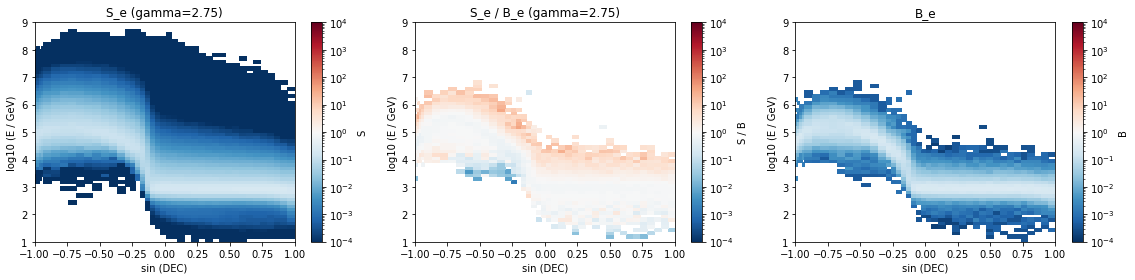

In [14]:
plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
plt.pcolor(S_sinDec_edges, S_logE_edges, S_e_hist, cmap='RdBu_r', vmin=0.0001, vmax=10000, norm=mpcolors.LogNorm())
plt.colorbar(label='S')
plt.title('S_e (gamma={})'.format(Get_E_dists.gamma))
plt.ylabel('log10 (E / GeV)')
plt.xlabel('sin (DEC)')
plt.ylim(1,9)

plt.subplot(1,3,2)
plt.pcolor(S_sinDec_edges, S_logE_edges, S_e_hist / B_e_hist, cmap='RdBu_r', vmin=0.0001, vmax=10000, norm=mpcolors.LogNorm())
plt.colorbar(label='S / B')
plt.title('S_e / B_e (gamma={})'.format(Get_E_dists.gamma))
plt.ylabel('log10 (E / GeV)')
plt.xlabel('sin (DEC)')
plt.ylim(1,9)

plt.subplot(1,3,3)
plt.pcolor(S_sinDec_edges, S_logE_edges, B_e_hist, cmap='RdBu_r', vmin=0.0001, vmax=10000, norm=mpcolors.LogNorm())
plt.colorbar(label='B')
plt.title('B_e')
plt.ylabel('log10 (E / GeV)')
plt.xlabel('sin (DEC)')
plt.ylim(1,9)

plt.tight_layout()
plt.show()

In [34]:
#TS Calculation checks
sstest = np.array([0.1,0.1,0.1,0.3,1.2])
bstest = np.array([0.5,0.5,0.5,0.4,0.1])
setest = np.array([.005,.005,.007,.05,.1])
betest = np.array([0.1,0.1,0.1,0.01,0.001])
nstest = 3.1

Test_TS = Single_Source_TestStatistic(sstest, bstest, setest, betest)

print("Calculated TS for given weights and ns: ", Test_TS.calc_TS(nstest))
print("Minimized TS and best fit ns for given weights (ns, TS): ", Test_TS.minimize_TS())

Calculated TS for given weights and ns:  -9.519709710887211
Minimized TS and best fit ns for given weights (ns, TS):  (1.6676225732855772, -10.88854617086713)


In [ ]:
plt.hist(dataS_norm, bins=50)
plt.xlabel('Normalized Signal Probability (Spatial * Energy)')
plt.ylabel('Event Count')
plt.loglog()

plt.show()

In [ ]:
#Trial Correction for binned pvalues, and Crab Nebula bin--------------

hottest_corrected_pval = len(hot_pvals[hot_pvals < hot_pvals[0]]) / num_trials
CN_corrected_pval = len(CN_pvals[CN_pvals < CN_pvals[0]]) / num_trials

print('Pre-trial Hottest P-value:', hot_pvals[0])
print('Corrected Hottest P-value:', hottest_corrected_pval)
print('Pre-trial CN P-value:', CN_pvals[0])
print('Corrected CN P-value:', CN_corrected_pval)

#Crab Nebula Injection: How many events to get it to *2* sigma ?--------
#We will estimate a normal dist, so 2 sigma for one-tail is the pvalue that is lower than 97.8% of the trials...
#...and find the counts that gives this pvalue
#We start by constructing a dataframe for counts and pvalues of trials
scram_CN_df = pd.DataFrame(CN_pvals)
scram_CN_df.columns = ['Pval']
scram_CN_df['Pix Count'] = CN_counts

#Location of 2sigma pvalue after sorting---------
twoSigLoc = num_trials - int(np.rint(0.978 * num_trials))

scram_CN_df.sort_values(by='Pval', inplace=True)
display(scram_CN_df)
print('-------Two Sigma--------')
display(scram_CN_df.iloc[twoSigLoc])
print('--------CN Data---------')
display(scram_CN_df.loc[0])

CN_2sig_pval = scram_CN_df.iloc[twoSigLoc,0]

In [ ]:
#Plotting lowest p-value distr for binned analysis scrambles...

n,e,p = plt.hist(-np.log10(hot_pvals), bins=100)
plt.vlines(-np.log10(hot_pvals[0]),0,50, color='r', label='Lowest Data P-value')

#plt.hist(hot_pvals, bins=100)
#plt.vlines(hot_pvals[0],0,50, color='r', label='Lowest Data P-value')

plt.xlabel('-log10(Pval)')
plt.ylabel('Counts')
plt.title('{} Scrambles: Lowest P-value'.format(num_trials))
#plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
#Crab Nebula binned p-values for scrambles...

plt.hist(-np.log10(CN_pvals), bins=100)
plt.vlines(-np.log10(CN_pvals[0]),0,150, color='r', label='Pre-trial P-value')
#plt.vlines(-np.log10(CN_corrected_pval),0,150, color='g', label='Corrected P-value')
plt.vlines(-np.log10(CN_2sig_pval),0,150, color='k', label='2sigma P-value')

#plt.hist(CN_pvals, bins=100)
#plt.vlines(CN_pvals[0],0,150, color='r', label='Pre-trial P-value')
#plt.vlines(CN_corrected_pval,0,150, color='g', label='Corrected P-value')
#plt.vlines(CN_2sig_pval,0,150, color='k', label='2sigma P-value')

plt.xlabel('-log10(P-Value)')
plt.ylabel('Counts')
#plt.yscale('log')
plt.title('{} Scrambles: Crab Nebula Pre-trial P-values'.format(num_trials))
plt.legend()
plt.show()

Fraction of TS < 0 : 0.108
Median TS:  0.0
Chi2 Fit DoF:  1.3667358324541938
Chi2 Fit loc:  0.00024537845366403216
Chi2 Fit scale:  1.0143200606465839


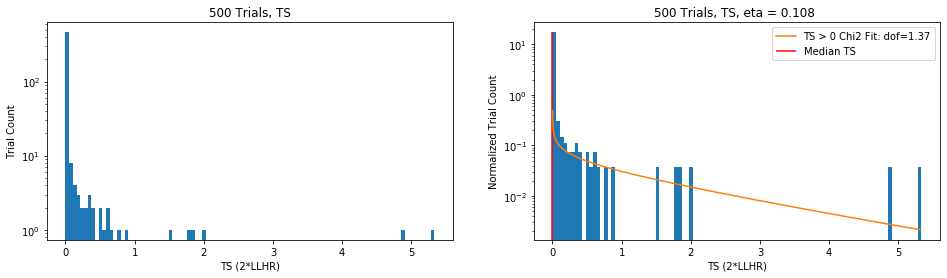

In [44]:
PlotTSandChi2(TS_arr, num_trials, loglog=False, bins=100, nochinorm=False)

In [ ]:
nss = np.arange(0,2,.01)
ys = []
for ns in nss:
    ys.append(Do_TS_Calcs.calc_TS(ns))
plt.plot(nss, ys)
plt.vlines(bf_ns,np.min(ys),np.max(ys), linestyle='--', label='Best Fit ns')
plt.xlabel('ns')
plt.ylabel('TS')
plt.title('ns = {}'.format(np.round(bf_ns,3)))
plt.legend()
plt.show()

In [ ]:
#Evaluating at Grid Points
#Set grid points
#1 deg x 1 deg square around GC, .2 deg steps
#NOTE: .5 deg = .00873 rad
#      .2 deg = .00349 rad

grid_decs = np.arange(GC_dec-.00873, GC_dec+.00873, .00349)
grid_ras  = np.arange(GC_ra-.00873, GC_ra+.00873, .00349)
dd, rr = np.meshgrid(grid_decs, grid_ras)

grid_dec_coords = dd.flatten()
grid_ra_coords = rr.flatten()

#Loop over grid points, get ns and TS at each
grid_ns_list = []
grid_TS_list = []
for grid_dec, grid_ra in zip(grid_dec_coords, grid_ra_coords):
    Grid_Spatial = Single_Source_Spatial_Dists(Data_DEC, RA_use, Data_AngErr, grid_dec, grid_ra)
    S_s = Grid_Spatial.signal_spatial()
    B_s = Grid_Spatial.background_spatial()
    
    Grid_TS_Calc = Single_Source_TestStatistic(S_s, B_s, S_e, B_e)
    bf_ns, TS = Grid_TS_Calc.minimize_TS()
    
    grid_ns_list.append(bf_ns)
    grid_TS_list.append(TS)

#Make lists into arrays
grid_ns_list = np.array(grid_ns_list)
grid_TS_list = np.array(grid_TS_list)

#Get Pvalue from trial TS distribution
grid_pval_list = []
for ts in grid_TS_list:
    pval = np.mean(TS_arr <= ts)
    grid_pval_list.append(pval)

grid_pval_list = np.array(grid_pval_list)

print(grid_pval_list)